# Domain Definiftions

In [106]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import deque as stack
from dataclasses import dataclass
from enum import Enum
from typing import List, Set, Dict, Tuple, Optional


In [107]:
@dataclass(frozen=False)
class Node:
    x: int
    y: int
    blocked: bool

    def __init__(self, x: int, y: int):
        self.x = x
        self.y = y
        self.blocked = False if (x == 0 and y == 0) else Node.draw_blocking_condition()

    @property
    def id(self) -> Tuple[int, int]:
        return self.x, self.y

    def is_blocked(self):
        return self.blocked

    def is_free(self):
        return not self.blocked

    @classmethod
    def from_tuple(cls, t: Tuple[int, int]):
        return Node(t[0], t[1])

    """
    Generate a binomial random distribution of '0' and '1's
    where '0's represent the node is blocked, and therefore 
    it cannot be reached
    """
    @classmethod
    def draw_blocking_condition(cls):
        dist = np.random.binomial(1, 0.75)
        return True if dist == 0 else False

    def __hash__(self):
        return self.id.__hash__()

In [108]:
class Terrain(Enum):
    Asphalt = ("Terra", 1)
    Flooding = ("Agua", 3)
    Quicksand = ("Areia Movedica", 6)

    @classmethod
    def lookup(cls, id: int) -> Optional['Terrain']:
        terrain_map = {
            0: Terrain.Flooding,
            1: Terrain.Quicksand,
            2: Terrain.Asphalt
        }
        return terrain_map.get(id, Terrain.Asphalt)

    """
    Generate a binomial random distribution of '0', '1's and '2's 
    with 80% chance to get a '2', where the IDs defining each terrain are
    set in the Terrain class:
    """
    @classmethod
    def draw_terrain(cls):
        dist = np.random.binomial(2, 0.8)
        return Terrain.lookup(dist)

In [109]:
@dataclass(frozen=False)
class Edge:
    source: Node
    destination: Node
    terrain: Terrain

    def __init__(self, source: Node, dest: Node, terrain: Terrain = Terrain.Asphalt):
        self.source = source
        self.destination = dest
        self.terrain = terrain

    @property
    def weight(self):
        return self.terrain.value[1]

    def update_terrain(self, terrain: Terrain):
        self.terrain = terrain

In [110]:
@dataclass(frozen=False)
class Graph:
    nodes: Dict[Tuple[int,int], Node]
    edges: Dict[Tuple[Node,Node], Edge]

    def __init__(self):
        self.nodes = dict()
        self.edges = dict()

    @classmethod
    def from_adjacency_list(cls, adj_list: Dict[Tuple, List[Tuple]]):
        pass

    def get_node(self, x: int, y: int) -> Optional[Node]:
        return self.nodes.get((x, y))

    def get_all_nodes(self) -> List[Node]:
        return list(self.nodes.values())

    def get_available_nodes(self) -> List[Node]:
        all_nodes = self.get_all_nodes()
        return list(filter(lambda node: node.is_free(), all_nodes))

    def get_blocked_nodes(self) -> List[Node]:
        all_nodes = self.get_all_nodes()
        return list(filter(lambda node: node.is_blocked(), all_nodes))

    def get_all_edges(self) -> List[Edge]:
        return list(self.edges.values())

    def find_edge_connecting(self, source: Node, target: Node) -> Optional[Edge]:
        return self.edges.get((source, target))

    def find_edges_whose_source_is(self, node: Node) -> List[Edge]:
        neighbors: List[Node] = self.find_neighbors_of(node)
        return [self.find_edge_connecting(node, neighbor) for neighbor in neighbors]

    def find_neighbors_of(self, node: Node) -> List[Node]:
        if node.is_free():
            for pos in self._find_neighbors_pos_estimation(node):
                neighbor: Optional[Node] = self.nodes.get(pos)
                if neighbor != None and neighbor.is_free():
                    yield self.nodes.get(pos)

    """
    estimated positions return a list of expected neighbors as follows:
    up, down, left, right, up_right, up_left, down_right, down_left
    """

    def _find_neighbors_pos_estimation(self, node: Node):
        pos = node.id
        return [(pos[0], pos[1]-1),    # Up
                (pos[0], pos[1]+1),    # Down
                (pos[0]-1, pos[1]),    # Left
                (pos[0]+1, pos[1]),    # Right
                (pos[0]+1, pos[1]-1),  # Up Right
                (pos[0]-1, pos[1]-1),  # Up Left
                (pos[0]+1, pos[1]+1),  # Down Right
                (pos[0]-1, pos[1]+1)]  # Down Left

    def with_node(self, node: Node):
        self.nodes[node.id] = node
        return self

    def with_nodes(self, nodes: List[Node]):
        [self.with_node(node) for node in nodes]
        return self

    def with_edge(self, edge: Edge):
        src = edge.source
        dest = edge.destination
        self.edges[src, dest] = edge
        return self

    def with_edges(self, edges: List[Edge]):
        [self.with_edge(edge) for edge in edges]
        return self

    def reset(self):
        return Graph()

# Graph Construction

### Building the graph

In [111]:
area_width = 10
area_height = 10

In [112]:
# Refactor this to use an adjacency_list

def generate_nodes(width: int, height: int):
    for row_num in range(width):
        for col_num in range(height):
            yield Node(row_num, col_num)

nodes = list(generate_nodes(area_width, area_height))

In [113]:
graph = Graph().with_nodes(nodes)

In [114]:
for node in graph.get_available_nodes():
    neighbors: List[Node] = graph.find_neighbors_of(node)
    edges: List[Edge] = [Edge(node, neighbor) for neighbor in neighbors]
    graph.with_edges(edges)


### Sorting the Nodes to change the Terrain type

# PathFinder Algorithm

### A* Implementation

In [115]:
class AStarAlgorithm:
    graph: Graph
    visited_nodes: Set[Node]

    def __init__(self, graph: Graph):
        self.graph = graph

    def shortest_path_between(self, source: Node, target: Node) -> List[Node]:
        self.visited_nodes = set()
        self.path_stack = stack()
        return self._shortest_path_between(source, target)

    def _shortest_path_between(self, source: Node, target: Node) -> List[Node]:
        neighbors: Set[Node] = set(graph.find_neighbors_of(source))
        available_neighbors = neighbors.difference(self.visited_nodes)

        if source == target:
            self.path_stack.append(source)
            return self.path_stack

        else:
            if len(available_neighbors) > 0:
                edges: List[Edge] = [graph.find_edge_connecting(source, neighbor) for neighbor in available_neighbors]
                nodes_heuristics = [a_star.distance_between(edge.destination, target, edge.weight) for edge in edges]
                best_node_heuristics = min(nodes_heuristics, key=lambda h: h[1])
                selected_neighbor = best_node_heuristics[0]

                self.visited_nodes.add(source)
                self.path_stack.append(source)
                return self._shortest_path_between(source=selected_neighbor, target=target)

            else:
                # Rollback
                try:
                    last_visited_node = self.path_stack.pop()
                    self.visited_nodes.remove(last_visited_node)
                    self.visited_nodes.add(source)
                    return self._shortest_path_between(source=last_visited_node, target=target)
                except IndexError:
                    return self.path_stack

    def distance_between(self, node: Node, target: Node, cost_to_node: int):
        euclidian_dist = pow(target.x - node.x,2) + pow(target.y - node.y,2)
        heuristic = math.sqrt(euclidian_dist) + cost_to_node
        return node, heuristic


In [116]:
a_star = AStarAlgorithm(graph)
source = graph.nodes.get((0, 0))
target = graph.nodes.get((area_width-1, area_height-1))


In [117]:
path = a_star.shortest_path_between(source, target)
path

deque([Node(x=0, y=0, blocked=False),
       Node(x=0, y=1, blocked=False),
       Node(x=1, y=2, blocked=False),
       Node(x=2, y=3, blocked=False),
       Node(x=3, y=4, blocked=False),
       Node(x=4, y=5, blocked=False),
       Node(x=5, y=6, blocked=False),
       Node(x=5, y=7, blocked=False),
       Node(x=6, y=8, blocked=False),
       Node(x=7, y=9, blocked=False),
       Node(x=8, y=9, blocked=False),
       Node(x=9, y=9, blocked=False)])

In [118]:
graph.get_blocked_nodes()

[Node(x=0, y=2, blocked=True),
 Node(x=0, y=7, blocked=True),
 Node(x=0, y=8, blocked=True),
 Node(x=1, y=1, blocked=True),
 Node(x=1, y=7, blocked=True),
 Node(x=1, y=8, blocked=True),
 Node(x=2, y=1, blocked=True),
 Node(x=2, y=6, blocked=True),
 Node(x=3, y=6, blocked=True),
 Node(x=4, y=2, blocked=True),
 Node(x=4, y=3, blocked=True),
 Node(x=5, y=3, blocked=True),
 Node(x=5, y=8, blocked=True),
 Node(x=6, y=3, blocked=True),
 Node(x=6, y=6, blocked=True),
 Node(x=6, y=7, blocked=True),
 Node(x=6, y=9, blocked=True),
 Node(x=7, y=6, blocked=True),
 Node(x=7, y=8, blocked=True),
 Node(x=8, y=3, blocked=True),
 Node(x=8, y=4, blocked=True),
 Node(x=9, y=4, blocked=True),
 Node(x=9, y=6, blocked=True),
 Node(x=9, y=7, blocked=True)]

# Graph Visualization

In [119]:
G = nx.DiGraph()

for edge in graph.get_all_edges():
    G.add_edge(edge.source.id, edge.destination.id, weight=edge.weight)

for node in graph.get_blocked_nodes():
    G.add_node(node.id)

In [120]:
pos = dict((node, node) for node in G.nodes())

In [121]:
isolated = set(nx.isolates(G))
non_isolated = set(G.nodes()).difference(isolated)

In [122]:
edges_path = set()
for i in range(len(path)-1):
    curr_node = path[i]
    next_node = path[i+1]
    edges_path.add((curr_node.id, next_node.id))

Loading graph...


(-0.945, 9.944999999999999, -0.945, 9.944999999999999)

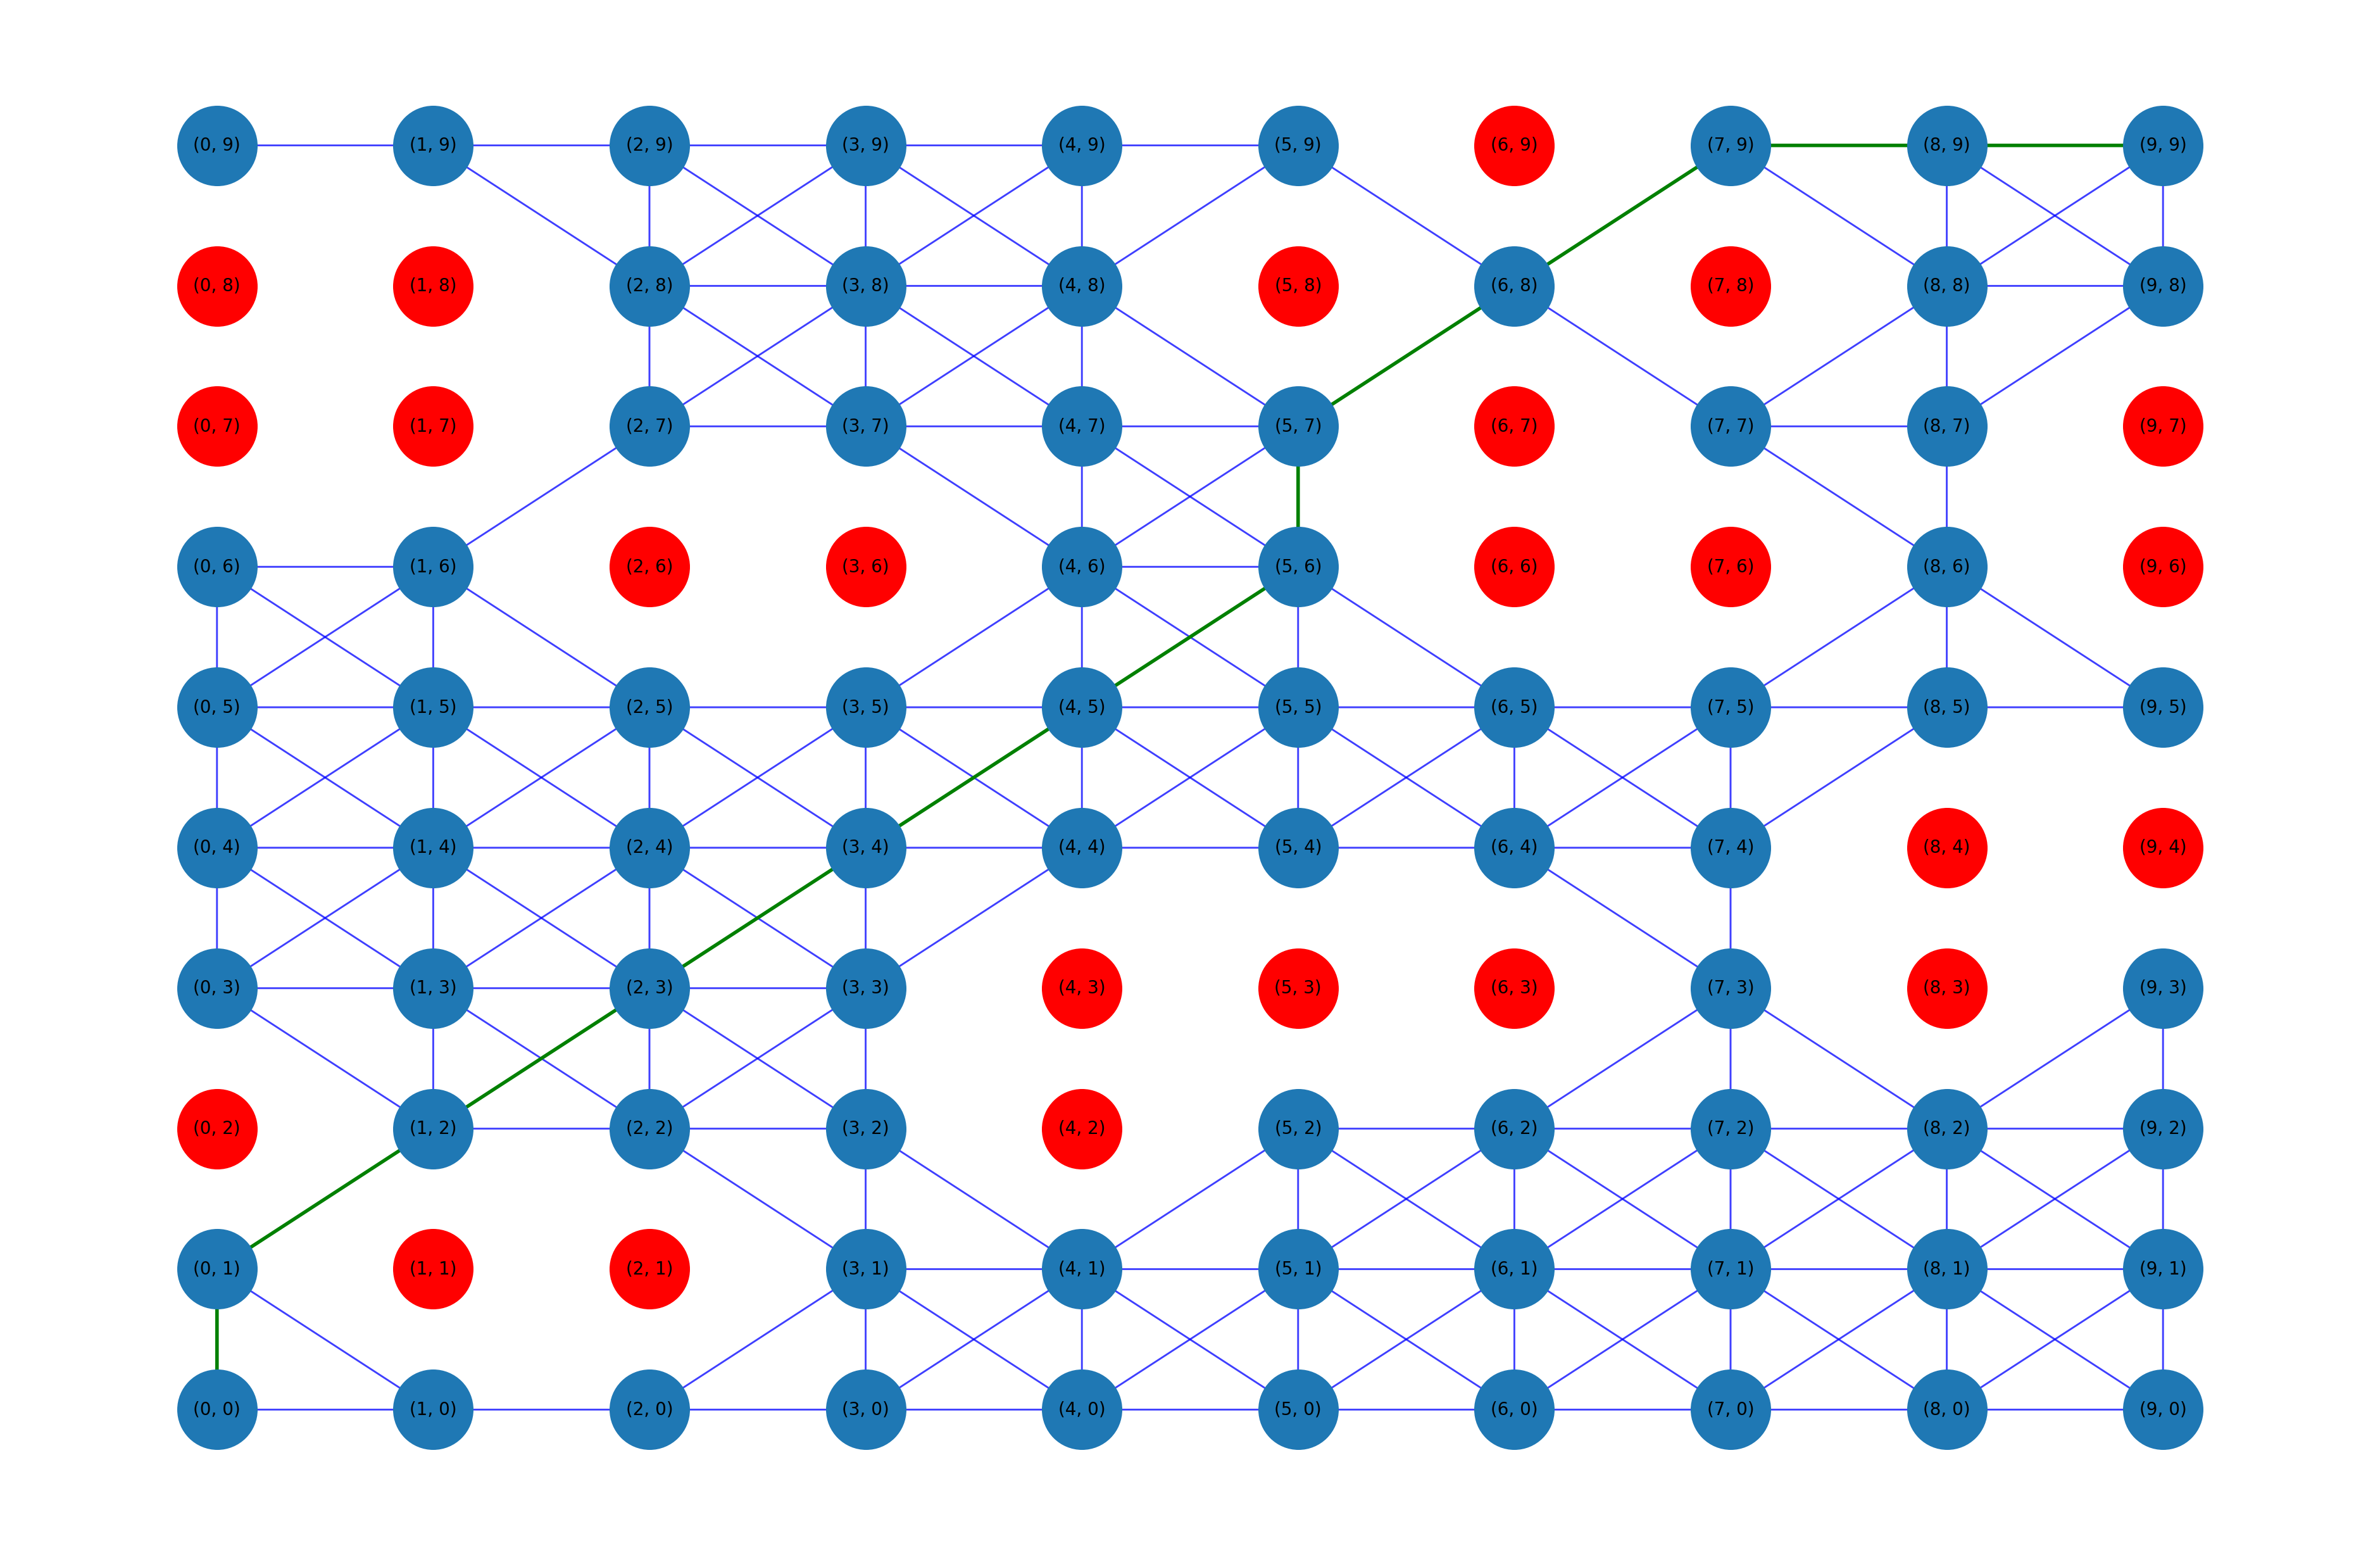

In [123]:
print("Loading graph...")
nx.draw_networkx_nodes(G, pos, nodelist=isolated, node_color='r', node_size=2000)
nx.draw_networkx_nodes(G, pos, nodelist=non_isolated, node_size=2000)
nx.draw_networkx_edges(G, pos, edgelist=G.edges, width=1, alpha=0.5, edge_color="b")
nx.draw_networkx_edges(G, pos, edgelist=edges_path, width=2, alpha=1, edge_color="g")
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.rcParams['figure.figsize'] = [24, 16]
plt.rcParams['figure.dpi'] = 200
plt.axis("off")